# Clustering Routine

This Jupyter Notebook can be ran after the initial crawling with the *crawl.py* python script to categorize a big number of news articles by their topics. The duration of the Jupyter Notebook processing time may vary depending on your dataset size. You can estimate at least a few hours for datasets bigger than 50 000 articles.

# Routine Of The Jupyter Notebook

This algorithm can be structured into the following main components:

1. Load crawled dataset from the folder *./crawl_json/*.
2. Preprocessing.
3. Visualize the data with wordclouds.
4. LDA Clustering.
5. Find the optimal amount of clusters with the coherence score.
6. Visualize the optimal topic clusters with LDAvis.
7. Subcluster all news articles by their release date.
8. Sort all documents into a folder hierarchy *./clustered_json/* to represent the cluster topics.


# Open Data From JSON
First we have to load our previously cralwed dataset into memory.

In [1]:
import pandas as pd
import numpy as np
import os
import glob

In [2]:
path = 'crawl_json/'
frames = []
for filename in glob.glob(os.path.join(path, '*.json')): #only process .JSON files in folder.      
    with open(filename, encoding='utf-8', mode='r') as currentFile:
        frames.append(pd.read_json(currentFile, orient='index'))

df = pd.concat(frames)
df.drop(['authors', 'image_url', 'localpath', 'title_page', 'title_rss'], axis = 1, inplace = True)
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...


# Amount of articles that will be processed:

In [3]:
amount_of_articles = len(df["maintext"])
print(f"Amount of articles: {amount_of_articles}")

Amount of articles: 239225


# Preprocessing 

We will now continue with preparing the data for the actual clustering. Therefore we are lemmatizing all strings and removing all words that aren't nouns.

In [4]:
import re

In [5]:
df['id'] = df.index
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2


In [6]:
# Remove punctuation
df['maintext_prepro'] = \
df['maintext'].map(lambda x: re.sub('[,\.!?]', '', x))
# To lowercase
df['maintext_prepro'] = \
df['maintext_prepro'].map(lambda x: x.lower())

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
is_noun = lambda pos: pos[:2] == 'NN'
nouns = []

stemmer = WordNetLemmatizer()

estimated_minutes = amount_of_articles * 0.000217

print(f'Tokenizing all articles. This may take a while. (Estimate: ~{ round(estimated_minutes, 2) } minutes)')
df['tokenized_words'] = df['maintext'].apply(nltk.word_tokenize)
print("Finished tokenizing all articles. Continue with lemmatization & noun extraction.")


Tokenizing all articles. This may take a while. (Estimate: ~35.6 minutes)
Finished tokenizing all articles. Continue with lemmatization & noun extraction.


In [ ]:
print("Lemmatization & noun extraction is running...")
for element in tqdm(df["tokenized_words"]):
	nouns.append(" ".join([stemmer.lemmatize(word) for (word, pos) in nltk.pos_tag(element) if is_noun(pos) and len(word) > 2]))    # joined as a single string per article

print("Finished lemmatization & noun extraction.")
df["maintext_nouns"] = nouns

Lemmatization & noun extraction is running...


100%|██████████| 164036/164036 [2:54:57<00:00, 15.63it/s]

Finished lemmatization & noun extraction.


In [ ]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...


# Word Cloud

The following word clouds will give you a general idea about how each step in preprocessing improves the quality of the dataset for our use case. The bigger a word is shown, the more frequent is its existence in our dataset. 

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1000, height=400, background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Word Cloud All Words

This word cloud includes all words of the articles without major filtering.

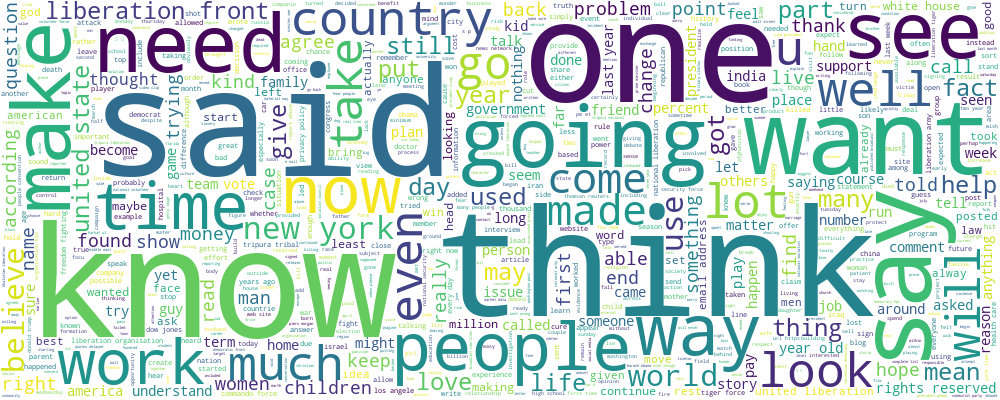

In [ ]:
all_articles_string = ','.join(list(df['maintext_prepro'].values))
wordcloud.generate(all_articles_string)

wordcloud.to_image()

# Word Cloud Only Nouns

This word cloud shows you only the nouns of the acticles.

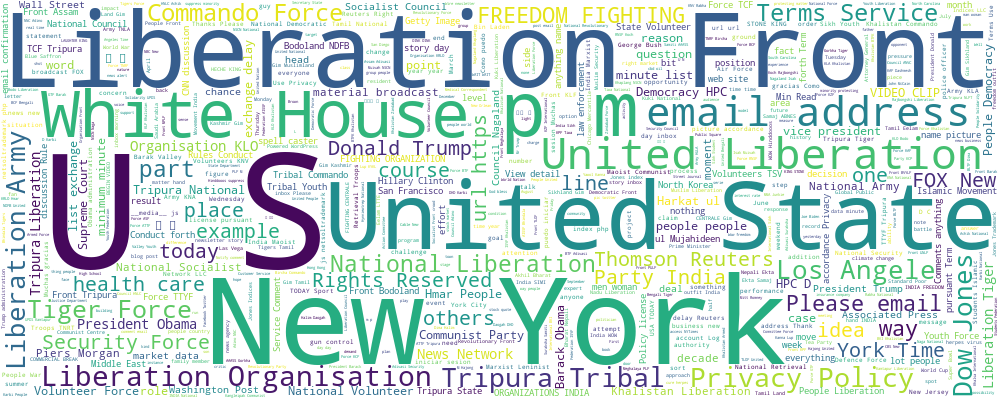

In [ ]:
all_articles_nouns = ','.join(list(df['maintext_nouns'].values))
wordcloud.generate(all_articles_nouns)

wordcloud.to_image()

# Prepare data for LDA analysis

We will continue preparing our data for the LDA clustering by removing predefined stopwords (extended by *./stopwords.json*) and filtering out unwanted characters.

In [ ]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import json
import regex

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
stop_words = stopwords.words('english')

with open("stopwords.json") as jsonFile:
    jsonStopwords = json.load(jsonFile)

#extend stopwords if desired
stop_words.extend(jsonStopwords)  


In [ ]:
#Tokenize Text
def sentence_to_words(sentences):
    for sent in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(sent, deacc=True))

In [ ]:
#Remove Stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if (word not in stop_words)] for doc in texts]    #filtering

In [ ]:
#Remove non alphanumeric words
def remove_non_alphanumeric(texts):
    return [[word for word in list if word.isalnum()] for list in texts]

In [ ]:
def remove_non_ASCII(lists):
    for list in lists:
        for i, string in enumerate(list):
            if string.isascii():
                continue
            else:
                list.pop(i)
    return lists

In [ ]:
maintext_data = df["maintext_nouns"].values.tolist()
df["maintext_ready"] = list(sentence_to_words(maintext_data))

maintext_ready = remove_stopwords(df["maintext_ready"].tolist())
maintext_ready = remove_non_ASCII(maintext_ready)
df["maintext_ready"]  = maintext_ready

In [ ]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, talk,..."
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...,"[brands, publisher, esports, sponsorship, oppo..."
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, fareed,..."


# Wordcloud of the ready-to-cluster articles

This is the word cloud of the dataset which we will actually apply out LDA clustering on.

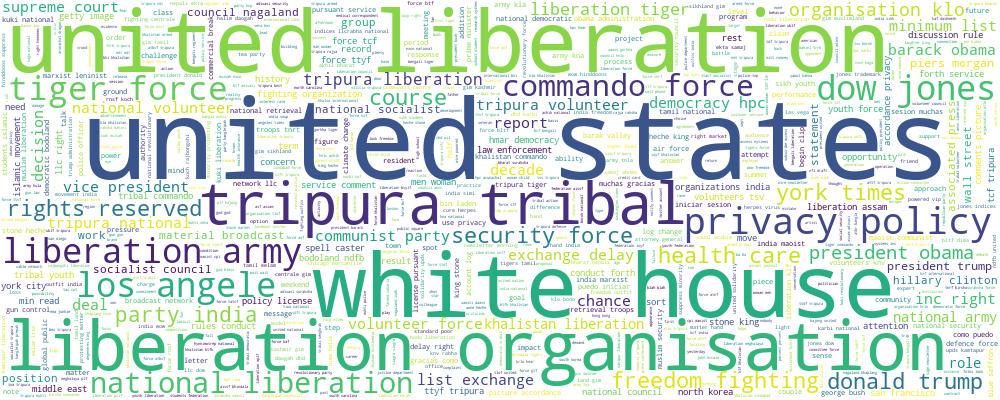

In [ ]:
ready_wordlist = []
for element in df["maintext_ready"]:
    ready_wordlist.append(','.join(list(element)))

all_articles_ready = ','.join(ready_wordlist)
wordcloud.generate(all_articles_ready)

wordcloud.to_image()

# Create the Corpus

Creating a corpus is needed to have data that is understandable to gensim. This will be given to the LDA algorithm to perform the clustering.

In [ ]:
import gensim.corpora as corpora

In [ ]:
data = df["maintext_ready"].tolist()

word_dictionary = corpora.Dictionary(data)

corpus = [word_dictionary.doc2bow(text) for text in data]   #create the corpus

df["corpus"] = corpus

In [ ]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, talk,...","[(0, 2), (1, 1), (2, 1), (3, 2), (4, 1), (5, 2..."
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...,"[brands, publisher, esports, sponsorship, oppo...","[(24, 1), (25, 1), (26, 1), (27, 7), (28, 1), ..."
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, fareed,...","[(3, 1), (24, 5), (54, 1), (82, 1), (95, 1), (..."


# Build a LDA model & calculate Coherence Score

The following code is going through a prefined range of topic amounts to check which clustering approach suits the dataset best. Each iteration inlcludes the clustering of all articles and the calculation of the coherence score. A sudden drop in the coherence score will trigger an Elbow Method. The algorithm will continue with taking the best possible clusters from there on.

In [ ]:
from pprint import pprint   #pretty printing
from gensim.models import CoherenceModel

In [ ]:
topic_amount_start = 30     #specify where to start generating clusters
topic_amount_end = 300      #specify the maximum amount of clusters
iteration_interval = 5    
elbow_tolerance = 0.03     #specify how sensitive the Elbow Method should trigger.

In [ ]:
amount_of_topics = 0
best_coherence = 0

print(f"Calculating the optimal amount of clusters inbetween {topic_amount_start} and {topic_amount_end}.")

#Find the best possible coherence value inbetween the given min and max amount of articles. Continue with the best lda model found.
for amount_of_topics in range(topic_amount_start, topic_amount_end, iteration_interval):   
    lda_model = gensim.models.LdaMulticore(corpus = corpus, id2word = word_dictionary, num_topics = amount_of_topics, alpha=0.1, eta=0.01)   #build the LDA model

    cm = CoherenceModel(model=lda_model, texts=df["maintext_ready"].tolist(), dictionary=word_dictionary, coherence='c_v')     #calculate coherence
    coherence = cm.get_coherence()
    print(f"Coherence with {amount_of_topics} topics: ", coherence)

    if ( coherence < (best_coherence - elbow_tolerance) ):     #Elbow Method
        print(f"Elbow Method tolerance of {elbow_tolerance} met. Stopping to look at higher amounts of clusters because a sudden drop in clustering quality was detected.")
        break

    if (coherence > best_coherence):    #if the new coherence is better than before, save it as a new best.
        print("New best!")
        best_lda_model = lda_model
        best_coherence = coherence
        best_amount = amount_of_topics

print(f"Finished! Continuing with {best_amount} topic clusters. Coherence: {best_coherence}")


Calculating the optimal amount of clusters inbetween 30 and 300.
Coherence with 30 topics:  0.45563227172556137
New best!
Coherence with 35 topics:  0.4064704309913768
Early stopping tolerance of 0.03 met. Stopping to look at higher amounts of clusters because a sudden drop in clustering quality was detected.
Finished! Continuing with 30 topic clusters. Coherence: 0.45563227172556137


# Displaying the LDA model

This is the built LDA model. The first number represents the cluster ID. The other part shows you the propablity of words in the specific topic.

In [ ]:
pprint(best_lda_model.print_topics())
articles_lda = best_lda_model[corpus]

[(18,
  '0.012*"stone" + 0.012*"king" + 0.010*"heche" + 0.007*"บอล" + 0.007*"quote" '
  '+ 0.005*"right" + 0.005*"stock" + 0.005*"market" + 0.004*"sources" + '
  '0.004*"jones"'),
 (0,
  '0.019*"gun" + 0.007*"piers" + 0.006*"law" + 0.005*"right" + 0.005*"school" '
  '+ 0.005*"child" + 0.004*"man" + 0.004*"show" + 0.004*"police" + '
  '0.004*"morgan"'),
 (27,
  '0.027*"king" + 0.021*"heche" + 0.019*"stone" + 0.014*"jones" + 0.012*"dow" '
  '+ 0.009*"llc" + 0.007*"degeneres" + 0.007*"right" + 0.005*"inc" + '
  '0.005*"market"'),
 (28,
  '0.013*"obama" + 0.009*"president" + 0.006*"war" + 0.004*"election" + '
  '0.004*"woman" + 0.004*"romney" + 0.004*"party" + 0.004*"comment" + '
  '0.004*"bush" + 0.003*"campaign"'),
 (24,
  '0.006*"team" + 0.005*"game" + 0.005*"player" + 0.004*"league" + '
  '0.003*"king" + 0.003*"season" + 0.003*"stone" + 0.003*"united" + '
  '0.003*"cup" + 0.003*"right"'),
 (6,
  '0.004*"obama" + 0.004*"king" + 0.004*"president" + 0.004*"woman" + '
  '0.004*"gun" + 0.00

# Visualize the LDA model

This visualization is interactable and helps you identifying the quality of the LDA clustering by hand.

In [ ]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
from IPython.display import HTML, display

pyLDAvis.enable_notebook()

In [ ]:
LDAvis_data_filepath = os.path.join('./lda_results/ldavis_data_'+str(amount_of_topics)+'topics')

LDAvis_prepared = pyLDAvis.gensim_models.prepare(best_lda_model, corpus, word_dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

#load pre-prepared pyLDAvis data
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_data = pickle.load(f)
pyLDAvis.save_html(LDAvis_data, './lda_results/ldavis_data_'+ str(amount_of_topics) +'topics.html')
LDAvis_data #show the data

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
12     0.040936  0.058279       1        1  8.494424
29     0.007250  0.073684       2        1  7.085106
15     0.038160 -0.093961       3        1  6.961097
21    -0.275579 -0.012503       4        1  6.154057
26     0.022028  0.045122       5        1  5.721315
20    -0.013248  0.021345       6        1  5.332497
0     -0.005326  0.014820       7        1  4.807613
8      0.020151  0.033467       8        1  4.771953
9      0.016829  0.002914       9        1  4.232622
25     0.039182  0.011263      10        1  3.557281
28    -0.005510  0.039620      11        1  3.348633
5      0.001494  0.053901      12        1  3.315327
3     -0.011886  0.016160      13        1  3.266479
11     0.006885  0.045872      14        1  3.263857
14     0.023246 -0.024351      15        1  2.986790
24     0.019323 -0.053117      16        1  2.795238
10     0.011354  0.008625      17        1  2.778365
7     -0.002825  0.015267      18        1  2.707503
13     0.009560  0.005931      19        1  2.504568
16     0.016324 -0.050826      20        1  2.239628
22    -0.029436  0.000114      21        1  2.121427
2      0.021208 -0.019574      22        1  1.994394
1      0.009837 -0.017034      23        1  1.775335
27     0.020052 -0.061526      24        1  1.703097
18     0.042739 -0.063258      25        1  1.224869
17     0.024899  0.029888      26        1  1.190387
4      0.014673 -0.008395      27        1  1.106569
23    -0.018203 -0.019385      28        1  1.088915
19    -0.030327 -0.034787      29        1  0.879500
6     -0.013790 -0.017556      30        1  0.591155, topic_info=              Term           Freq          Total Category  logprob  loglift
823     liberation  141725.000000  141725.000000  Default  30.0000  30.0000
813           king  154682.000000  154682.000000  Default  29.0000  29.0000
65096      tripura  113925.000000  113925.000000  Default  28.0000  28.0000
1275         force  194024.000000  194024.000000  Default  27.0000  27.0000
148847       heche   87548.000000   87548.000000  Default  26.0000  26.0000
...            ...            ...            ...      ...      ...      ...
871       national     601.083261  142800.132340  Topic30  -6.3688  -0.3396
404          money     592.381885  129812.955393  Topic30  -6.3833  -0.2589
1275         force     608.171398  194024.888142  Topic30  -6.3570  -0.6344
2237       percent     582.233566  101485.027740  Topic30  -6.4006  -0.0299
668           city     579.844117  116092.201822  Topic30  -6.4047  -0.1685

[3059 rows x 6 columns], token_table=        Topic      Freq       Term
term                              
39157       8  0.960230        aao
223710      5  0.949493      aarti
31863       5  0.025874  abbotabad
31863       6  0.025874  abbotabad
31863      11  0.827980  abbotabad
...       ...       ...        ...
65313      14  0.012143  回顾一周重大新闻事
65313      15  0.004048  回顾一周重大新闻事
65313      18  0.004048  回顾一周重大新闻事
65313      22  0.012143  回顾一周重大新闻事
65313      24  0.004048  回顾一周重大新闻事

[36128 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 30, 16, 22, 27, 21, 1, 9, 10, 26, 29, 6, 4, 12, 15, 25, 11, 8, 14, 17, 23, 3, 2, 28, 19, 18, 5, 24, 20, 7])

# Store Cluster IDs to dataframe

To be able to correctly sort all articles into a floder hierachy wee need to store each articles cluster id into the dataframe.

In [ ]:
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric

topics = []
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]

lda_topics = best_lda_model.show_topics(num_words=5)
for topic in lda_topics:
    print(topic)
    topics.append(preprocess_string(topic[1], filters))

(22, '0.009*"police" + 0.005*"officer" + 0.004*"force" + 0.004*"president" + 0.003*"report"')
(8, '0.005*"care" + 0.005*"woman" + 0.005*"health" + 0.004*"house" + 0.004*"child"')
(10, '0.006*"president" + 0.005*"ufc" + 0.004*"china" + 0.004*"house" + 0.004*"washington"')
(11, '0.011*"president" + 0.005*"house" + 0.005*"government" + 0.004*"obama" + 0.004*"law"')
(5, '0.013*"india" + 0.006*"modi" + 0.004*"islam" + 0.004*"service" + 0.004*"die"')
(1, '0.008*"bank" + 0.006*"president" + 0.005*"market" + 0.005*"washington" + 0.004*"king"')
(19, '0.014*"access" + 0.008*"subscription" + 0.007*"times" + 0.007*"nytimes" + 0.005*"delivery"')
(12, '0.009*"herpes" + 0.009*"child" + 0.007*"doctor" + 0.006*"cure" + 0.005*"money"')
(23, '0.011*"access" + 0.009*"york" + 0.008*"nytimes" + 0.007*"times" + 0.005*"king"')
(17, '0.008*"oil" + 0.005*"president" + 0.004*"cbd" + 0.004*"woman" + 0.003*"god"')


C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topic_list = []
topic_percentage_list = []
topic_keywords_list = []

print(len(df))
for row in tqdm(articles_lda):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    topic_num = row[0][0]
    prop_topic = row[0][1]

    wp = best_lda_model.show_topic(topic_num)
    topic_keywords = ", ".join([word for word, prop in wp])
    topic_list.append(int(topic_num))
    topic_percentage_list.append(round(prop_topic,5))
    topic_keywords_list.append(topic_keywords)


df["clusterID"] = topic_list    ##the id of the topic
df["topic_percentage"] = topic_percentage_list  #how well the topic fits to this specifc article
df["topic_keywords"] = topic_keywords_list  #the dominant keywords for the topic

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


164036


100%|██████████| 164036/164036 [3:14:57<00:00, 14.02it/s]


In [ ]:
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus,clusterID,topic_percentage,topic_keywords
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, talk,...","[(0, 2), (1, 1), (2, 1), (3, 2), (4, 1), (5, 2...",0,0.68812,"gun, piers, law, right, school, child, man, sh..."
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...,"[brands, publisher, esports, sponsorship, oppo...","[(24, 1), (25, 1), (26, 1), (27, 7), (28, 1), ...",5,0.47912,"india, modi, islam, service, die, share, obama..."
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, fareed,...","[(3, 1), (24, 5), (54, 1), (82, 1), (95, 1), (...",5,0.99282,"india, modi, islam, service, die, share, obama..."


# Output LDA clustering to json files


In [ ]:
df = df.drop(columns=["maintext_prepro", "tokenized_articles", "maintext_nouns", "corpus", "id"], errors='ignore')   #drop unwanted attributes that should not be output into the json files.

filtered_maintext = [ " ".join(row["maintext_ready"]) for index, row in df.iterrows() ]   

df["filtered_maintext"] = filtered_maintext

df = df.drop(columns=["maintext_ready", "tokenized_words"])

df.head()

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,clusterID,topic_percentage,topic_keywords,filtered_maintext
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,0.68812,"gun, piers, law, right, school, child, man, sh...",neighbors forums general discussion talk denve...
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,5,0.47912,"india, modi, islam, service, die, share, obama...",brands publisher esports sponsorship opportuni...
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,5,0.99282,"india, modi, islam, service, die, share, obama...",update global public square show fareed take g...
3,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:08:18","Skip to main content Published: Jan 23, 2019 B...",en,jobs.washingtonpost.com,"Skip to main content Published: Jan 23, 2019By...",How Much Salary Negotiation Is Too Much?,https://jobs.washingtonpost.com/article/how-mu...,26,0.92709,"school, student, president, government, percen...",skip arden davidson salary balancing act price...
4,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:30",One of artist Shepard Fairey's next projects c...,en,latimesblogs.latimes.com,One of artist Shepard Fairey's next projects ...,Shepard Fairey puts services up for auction | ...,https://latimesblogs.latimes.com/culturemonste...,9,0.64727,"california, edt, president, business, drug, sc...",artist shepard fairey project portrait los ang...


# Generating folder structure

The following code creates the desired folder hierarchy and names each cluster after the top 3 dominant words in each one. Within each cluster/folder we are subclustering all articles by their release date.
The output json file has the format *year-month.json*. 

In [ ]:
import ujson

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df.reset_index(drop=True,inplace=True)

for cluster_id, data in df.groupby(df.clusterID):
    item = data.topic_keywords.iloc[0].split(",")
    with open(f'./lda_clustered_json/cluster_{cluster_id}-{item[0]}_{item[1]}_{item[2]}.json', 'w', encoding='utf-8') as f:
        f.write(ujson.dumps(data.to_dict('index'), indent=4, ensure_ascii=False, escape_forward_slashes=False))

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
